# First steps with sangria dataset

This notebook shows how to load the sangria data and have a first look using the LDC toolbox:
- Fourier transform
- SNR computation
- waveform projection and TDI computation

## Software requirements

- git clone https://gitlab.in2p3.fr/LISA/LDC
- pip install requirements.txt
- python setup.py build_liborbits install

Look at the LDC README for more details. 

## Downloading the sangria dataset

- https://lisa-ldc.lal.in2p3.fr/
- https://lisa-ldc.lal.in2p3.fr/media/uploads/LDC2_sangria_training_v1.h5

In [2]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import xarray as xr
from astropy import units as u
import pandas as pd

import ldc.io.hdf5 as hdfio
from ldc.lisa.noise import get_noise_model
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain
from ldc.common.series import TimeSeries, FrequencySeries
import ldc.waveform.fastGB as fastGB
from ldc.common.tools import compute_tdi_snr, window
from ldc.waveform.waveform import HpHc

/home/mtauraso/src/ldc-code/build/conda-env/lib/python3.7/typing.py:850: FutureWarning: xarray subclass TDI should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


## Loading the data

In [22]:
DATAPATH = "/home/mtauraso/src/LDC-data"
sangria_fn = DATAPATH+"/LDC2_sangria_training_v1.h5"
tdi_ts, tdi_descr = hdfio.load_array(sangria_fn, name="obs/tdi")

#dt = int(tdi_descr["dt"])
dt = int(1/tdi_descr["sampling_frequency"])

# Build timeseries and frequencyseries object for X,Y,Z
tdi_ts = xr.Dataset(dict([(k,TimeSeries(tdi_ts[k], dt=dt)) for k in ["X", "Y", "Z"]]))
tdi_fs = xr.Dataset(dict([(k,tdi_ts[k].ts.fft(win=window)) for k in ["X", "Y", "Z"]]))

#hdfio.display(sangria_fn)

## Looking at PSDs

(1e-05, 0.16817928305074292, 4e-22, 2e-19)

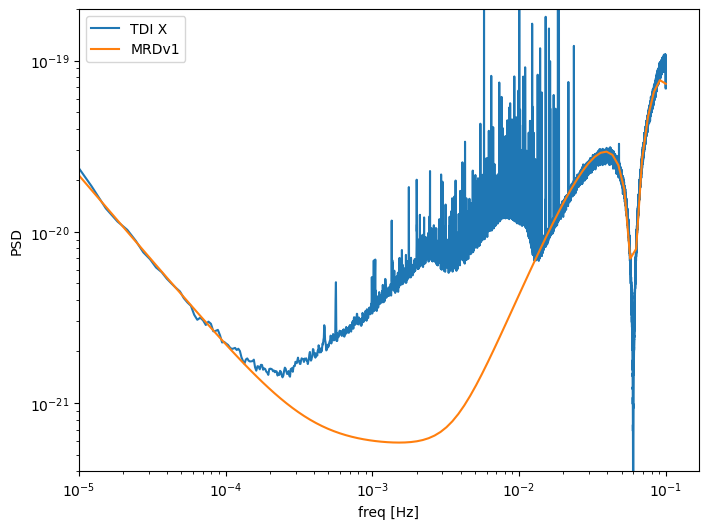

In [23]:
noise_model = "MRDv1"
Nmodel = get_noise_model(noise_model, np.logspace(-5, -1, 100))
Npsd = Nmodel.psd()

plt.figure(figsize=(8,6))
f, psdX =  scipy.signal.welch(tdi_ts["X"], fs=1.0/dt, window='hanning', nperseg=256*256)
plt.loglog(f, np.sqrt(psdX), label="TDI X")
plt.loglog(Nmodel.freq, np.sqrt(Npsd), label=noise_model, alpha=1)
plt.legend()
plt.xlabel("freq [Hz]")
plt.ylabel("PSD")
plt.axis([1e-5, None, 4e-22, 2e-19])

## Verification binary subtraction

In [24]:
vgb, units = hdfio.load_array(sangria_fn, name="sky/vgb/cat")
pd.DataFrame(vgb)

,Name,Amplitude,EclipticLatitude,EclipticLongitude,Frequency,FrequencyDerivative,Inclination,InitialPhase,Polarization
0,V407_Vul,3.295700e-23,0.816989,-1.135340,0.003512,2.785700e-17,1.506329,3.185514,2.861225
1,SDSS_J135154.46,6.168700e-23,0.078053,3.637054,0.002119,7.538331e-18,1.047198,0.400000,0.400000
2,AM_CVn,2.829120e-22,0.653451,2.973870,0.001944,6.489726e-18,1.047198,3.006892,2.117236
3,SDSS_J190817.07+394036.4,6.058848e-23,1.072578,5.204871,0.001842,3.856132e-18,0.261799,0.500000,0.500000
4,ZTF_J153932.16+502738.8,9.920754e-23,1.154700,3.578500,0.004822,2.758468e-16,1.468695,1.600000,1.600000
5,CR_Boo,2.935934e-22,0.312414,-2.752910,0.001360,9.622534e-18,0.523599,3.058156,3.562166
6,SDSS_J093506.92+441107.0,7.346080e-23,0.490263,2.286030,0.001667,2.189059e-18,1.221730,3.221988,3.044662
7,PTF1_J191905.19+481506.2,3.201751e-23,1.204785,5.393106,0.001484,1.366448e-18,1.047198,0.800000,0.800000
8,CD-30o11223,4.150747e-21,-0.289986,3.860292,0.000473,1.440030e-19,1.446878,1.700000,1.700000
9,SDSS_J092345.59+302805.0,2.638561e-22,0.251830,2.333754,0.000515,1.050732e-19,1.047198,1.500000,1.500000


Text(0.5, 0, 'freq [Hz]')

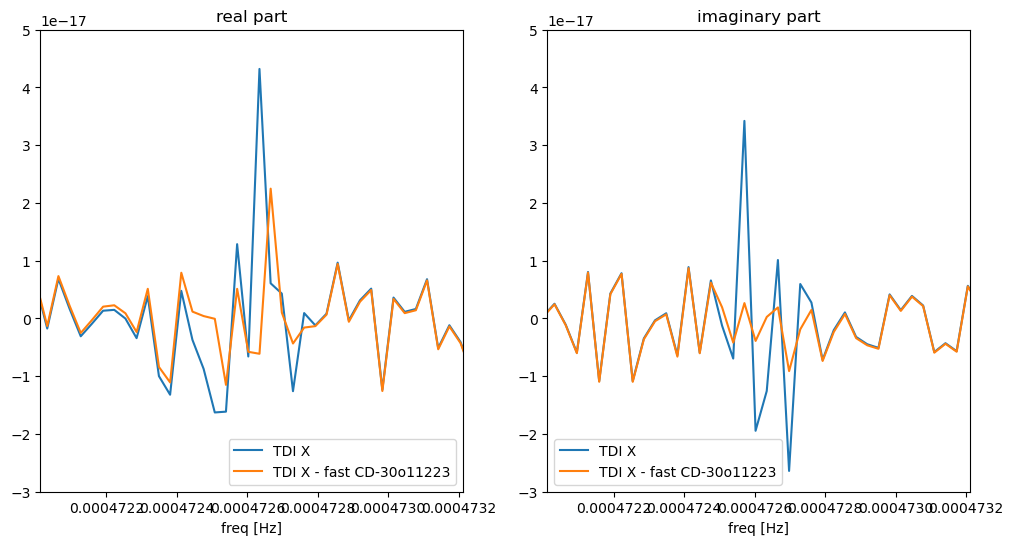

In [26]:
GB = fastGB.FastGB(delta_t=dt, T=float(tdi_ts["X"].t[-1])) # in seconds
pGB = dict(zip(vgb.dtype.names, vgb[8])) # we take the source #8
Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=4, simulator='synthlisa')

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("real part")
plt.plot(tdi_fs["X"].f, tdi_fs["X"].real, label="TDI X")
plt.plot(Xs.f, (tdi_fs["X"][Xs.kmin:Xs.kmin+len(Xs)]-Xs.values).real, label="TDI X - fast "+pGB["Name"])
plt.axis([pGB["Frequency"]-6e-7, pGB["Frequency"]+6e-7, -3e-17, 5e-17])
plt.legend(loc="lower right")
plt.xlabel("freq [Hz]")
plt.subplot(122)
plt.title("imaginary part")
plt.plot(tdi_fs["X"].f, tdi_fs["X"].imag, label="TDI X")
plt.plot(Xs.f, (tdi_fs["X"].isel(f=slice(Xs.kmin, Xs.kmin+len(Xs)))-Xs.values).imag, label="TDI X - fast "+pGB["Name"])
plt.axis([pGB["Frequency"]-6e-7, pGB["Frequency"]+6e-7, -3e-17, 5e-17])
plt.legend(loc="lower left")
plt.xlabel("freq [Hz]")

## Computing the SNR of verification binaries

In [27]:
vgb, units = hdfio.load_array(sangria_fn, name="sky/vgb/cat")
GB = fastGB.FastGB(delta_t=dt, T=float(tdi_ts["X"].t[-1])) # in seconds
noise_model = "MRDv1"
Nmodel = get_noise_model(noise_model, np.logspace(-5, -1, 100))
SNR2 = np.zeros((len(vgb), 2)) # snr square
for j,s in enumerate(vgb):
    pGB = dict(zip(vgb.dtype.names, s))
    Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=4, simulator='synthlisa')
    fmin, fmax = float(Xs.f[0]) , float(Xs.f[-1]+Xs.attrs['df'])
    source = dict({"X":Xs, "Y":Ys, "Z":Zs})
    SNR2[j,1] = compute_tdi_snr(source, Nmodel, data=tdi_fs, fmin=fmin, fmax=fmax)["tot2"]
    SNR2[j,0] = compute_tdi_snr(source, Nmodel)["tot2"] 

In [28]:
data = np.array([vgb["Name"], vgb["Frequency"], np.sqrt(SNR2[:,0]), np.sqrt(SNR2[:,1])]).T
pd.DataFrame(data, columns=["Name", "f0", "fastGB", "TDI"])

/home/mtauraso/src/ldc-code/build/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


,Name,f0,fastGB,TDI
0,V407_Vul,0.0035125,17.164281334876577,19.458751514012327
1,SDSS_J135154.46,0.002119003220884896,25.79433096189674,25.43163905860478
2,AM_CVn,0.00194414,97.35027775897906,98.46259941786428
3,SDSS_J190817.07+394036.4,0.0018421295017039697,30.124078540607428,15.648855243561382
4,ZTF_J153932.16+502738.8,0.004821699107149872,62.71433887719474,66.54680838154628
5,CR_Boo,0.00135962,79.01718945917271,77.68337782216278
6,SDSS_J093506.92+441107.0,0.00166667,15.449237076821754,14.454044102807167
7,PTF1_J191905.19+481506.2,0.0014843952944669167,5.986967891429243,nan
8,CD-30o11223,0.000472612,45.543646383796144,43.195961432345044
9,SDSS_J092345.59+302805.0,0.0005149728351829441,5.5589998830311025,6.229050914786007


## MBHBs subtraction

This part should be updated with a MBHB fast approximation provided by the ldc toolbox

In [29]:
mbhb, units = hdfio.load_array(sangria_fn, name="sky/mbhb/cat")
pd.DataFrame(mbhb)

,EclipticLatitude,EclipticLongitude,PolarAngleOfSpin1,PolarAngleOfSpin2,Spin1,Spin2,Mass1,Mass2,CoalescenceTime,PhaseAtCoalescence,InitialPolarAngleL,InitialAzimuthalAngleL,Redshift,Distance,ObservationDuration,Cadence
0,-0.303004,1.292518,1.203136,2.097304,0.747377,0.838800,1.323277e+06,6.124855e+05,1.152694e+07,1.220197,2.691982,1.808398,1.73941,13470.983559,3.155815e+07,3.0
1,-0.878570,4.549720,2.068669,1.097989,0.942824,0.870789,9.159926e+05,7.017527e+05,1.125857e+07,1.150360,1.899782,5.829771,1.10396,7705.852640,3.155815e+07,3.0
2,0.917031,3.584892,1.665850,2.092903,0.988778,0.975945,1.856420e+06,1.801541e+06,1.653219e+07,1.866057,1.410068,0.527915,4.57261,43010.925050,3.155815e+07,3.0
3,0.103452,0.224388,2.143049,1.656132,0.875693,0.882968,6.389298e+06,3.161571e+06,2.951609e+07,3.654661,1.576879,1.208145,8.08487,83307.076180,3.155815e+07,3.0
4,-0.521369,3.085541,2.582941,2.200156,0.825883,0.811360,3.128823e+06,2.640346e+06,1.860576e+07,3.425317,2.604701,1.670016,7.21026,73048.167218,3.155815e+07,3.0
5,0.636028,0.779159,2.332027,2.065443,0.574122,0.592671,1.773563e+06,1.083356e+06,1.116784e+07,2.311127,0.232802,3.798411,6.03496,59472.237592,3.155815e+07,3.0
6,-1.081082,4.052963,2.354232,1.689765,0.742128,0.989247,4.956676e+06,4.067167e+06,8.746488e+06,3.783309,0.963586,3.636925,6.17688,61097.116076,3.155815e+07,3.0
7,0.835250,3.257316,2.362671,1.539846,0.833674,0.981901,3.983915e+06,2.049535e+06,1.724516e+07,1.578620,2.323179,3.643228,3.34910,29747.551597,3.155815e+07,3.0
8,-0.317047,1.304027,2.302154,1.316011,0.927874,0.963228,1.238127e+06,1.136674e+06,2.440876e+07,5.213840,1.892711,2.667205,4.44948,41651.919868,3.155815e+07,3.0
9,1.288883,2.107165,0.624784,1.607191,0.953675,0.954511,1.349254e+06,1.195716e+06,2.042622e+07,3.435176,2.064630,4.287875,3.58897,32301.543286,3.155815e+07,3.0


In [45]:
def semi_fast_tdi(config, pMBHB, t_max, dt):
    """ Project h+,hx on LISA arm and compute TDI with time domain interpolation. 
    """
    hphc = HpHc.type("MBHB-%d"%s_index, "MBHB", "IMRPhenomD")
    hphc.set_param(pMBHB)
    orbits = Orbits.type(config)
    P = ProjectedStrain(orbits)    
    yArm = P.arm_response(0, t_max, dt, [hphc], tt_order=1)
    X = P.compute_tdi_x(np.arange(0, t_max, dt))
    return TimeSeries(X, dt=dt)

def my_load_config(filename, name="config"):
    """ Load configuration from dedicated group.
    """
    import h5py
    with h5py.File(filename, "r") as fid:
        print ("DTUFF")
        grp = fid.get(name)
        data = {}
        attr = {}
        for name in grp.keys():
            data[name] = str_decode(grp.get(name)[()])
            if 'units' in grp[name].attrs.keys():
                attr[name] = grp[name].attrs["units"]
    for k,v in attr.items():
        data[k] *= units.Unit(str(v))
    return data


config = my_load_config(sangria_fn, name="obs/config")
print(config)
config = hdfio.load_attributes(sangria_fn, name="obs/config")
#hdfio.display(sangria_fn)
print(config)
s_index = 13 # Look at 13th source
pMBHB = dict(zip(mbhb.dtype.names, mbhb[s_index]))
t_max = float(tdi_ts["X"].t[-1]+tdi_ts["X"].attrs["dt"])
Xs = semi_fast_tdi(config, pMBHB, t_max, dt)

{}
{'accnoise': 2.4e-15, 'dirname': 'run2', 'dt': "{'value': 3.0, 'units': 's'}", 'initial_position': "{'value': 0.0, 'units': 'rad'}", 'initial_rotation': "{'value': 0.0, 'units': 'rad'}", 'interp_order': 3, 'ldc_liborbits': '/codes/LDC/ldc/lisa/orbits', 'nbatch': 1, 'nominal_arm_length': "{'value': 2500000000.0, 'units': 'm'}", 'opticalnoise': 5e-12, 'orbit_type': 'analytic', 'readoutnoise': 6.35e-12, 't_max': "{'value': 31536000.0, 'units': 's'}", 't_min': "{'value': 0.0, 'units': 's'}", 'travel_time_order': 1}


TypeError: must be real number, not str

Text(0.5, 0, 'time [s]')

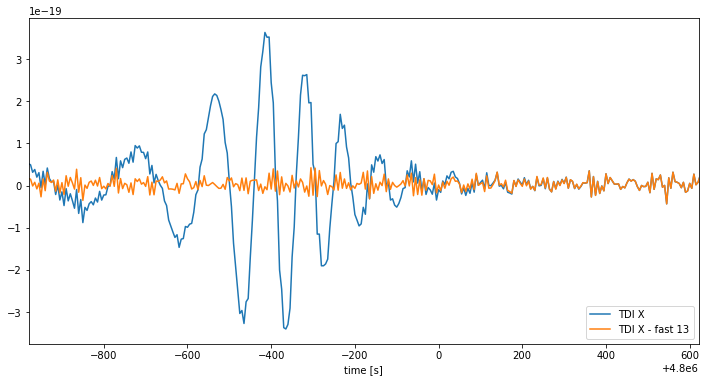

In [10]:
plt.figure(figsize=(12,6))
plt.plot(tdi_ts["X"].t, tdi_ts["X"], label="TDI X")
plt.plot(Xs.t, (tdi_ts["X"]-Xs), label="TDI X - fast %d"%s_index)
plt.axis([pMBHB["CoalescenceTime"]-1000, pMBHB["CoalescenceTime"]+600, None, None])
plt.legend(loc="lower right")
plt.xlabel("time [s]")

## Looking at simulation parameters

In [11]:
config = hdfio.load_config(sangria_fn, name="obs/config")
config

{'accnoise': 2.4e-15,
 'dirname': 'run2',
 'dt': <Quantity 3. s>,
 'initial_position': <Quantity 0. rad>,
 'initial_rotation': <Quantity 0. rad>,
 'interp_order': 3,
 'ldc_liborbits': '/codes/LDC/ldc/lisa/orbits',
 'nbatch': 1,
 'nominal_arm_length': <Quantity 2.5e+09 m>,
 'opticalnoise': 5e-12,
 'orbit_type': 'analytic',
 'readoutnoise': 6.35e-12,
 't_max': <Quantity 31536000. s>,
 't_min': <Quantity 0. s>,
 'travel_time_order': 1}

## Looking at noise free data

- MBHB TDI : https://lisa-ldc.lal.in2p3.fr/media/uploads/LDC2_sangria_mbhb-tdi_v1_MN5aIPz.h5
- VGB TDI: https://lisa-ldc.lal.in2p3.fr/media/uploads/LDC2_sangria_vgb-tdi_v1_sgsEVXb.h5
- Interacting GB TDI: https://lisa-ldc.lal.in2p3.fr/media/uploads/LDC2_sangria_idb-tdi_v1_DgtGV85.h5
- Detached GB TDI: https://lisa-ldc.lal.in2p3.fr/media/uploads/LDC2_sangria_gdb-tdi_v1_v3U3MxS.h5

In [12]:
X, attrs = hdfio.load_array(DATAPATH+"/mbhb-tdi.h5", name="X") # or Y, Z
dt = 1/attrs["sampling_frequency"]
ineg = np.where(X[:,0]>=0)[0][0]
X = TimeSeries(X[ineg:-1, 1], dt=dt) # remove negative time indices

Text(0.5, 0, 'time [s]')

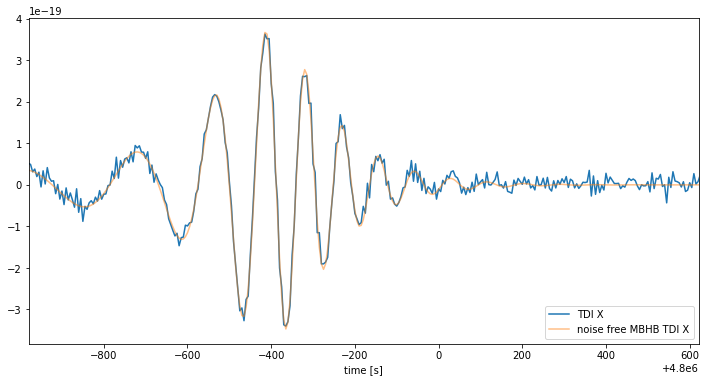

In [13]:
plt.figure(figsize=(12,6))
plt.plot(tdi_ts["X"].t, tdi_ts["X"], label="TDI X")
plt.plot(X.t, X, label="noise free MBHB TDI X", alpha=0.5)
plt.axis([pMBHB["CoalescenceTime"]-1000, pMBHB["CoalescenceTime"]+600, None, None])
plt.legend(loc="lower right")
plt.xlabel("time [s]")